<a href="https://colab.research.google.com/github/ali-workshop/improve-the-security-of-the-House-of-Representatives-building-cognitive-AI-three-simple-systems-/blob/main/The_use_of_cybersecurity_codes_with_cognitive_computing_to_improve_the_security_of_the_House_of_Representatives_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The House of Representatives building, as a cornerstone of democratic governance, is particularly vulnerable to cyber threats. This research endeavors to fortify the defenses against such threats through the amalgamation of a physical security system comprising Vicon sensors and facial recognition cameras, coupled with the analysis of Border Gateway Protocol (BGP) data, culminating in the development of a robust and all-encompassing Cyber-Physical System (CPS).

In the practical implementation of this system, Vicon sensors meticulously capture the physical movements within the House of Representatives building from multiple points and angles. Subsequently, cloud computing is employed to scrutinize the sensor data, providing an initial assessment of an individual's behavior as either aggressive or normal.

Simultaneously, surveillance cameras strategically positioned throughout the building focus on collecting facial features. These specialized cameras transmit images to an intelligent system that leverages cognitive computing for the final judgment on an individual's behavior. This two-pronged approach, integrating physical movement analysis and facial feature recognition, enhances the system's accuracy in behavioral assessment.

To harmonize the cyber (computing and communication) and physical (sensors, actuators, and processes components)
communication and routing protocols are monitored closely. This entails the examination of the BGP protocol, a border gateway protocol responsible for dynamically managing data and controlling routing and communication protocols. Cognitive computing is employed in this context to identify and categorize cyber attacks on the network infrastructure surrounding the House of Representatives building.

By integrating and analyzing BGP data within the CPS, a comprehensive understanding of both physical and network security is achieved. This integrated CPS system stands poised to provide accurate and layered protection for the House of Representatives, encompassing both the physical and cyber dimensions of security.

#import important libraries

In [ ]:
# Import necessary libraries
import pandas as pd  # Pandas for data manipulation and analysis
import numpy as np   # NumPy for numerical operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns   # Seaborn for statistical data visualization
import plotly.express as px   # Plotly Express for interactive visualizations

# Import TensorFlow and related modules for deep learning tasks
import tensorflow as tf   # TensorFlow for machine learning tasks
from tensorflow.keras.preprocessing.image import ImageDataGenerator   # ImageDataGenerator for data augmentation
from tensorflow.keras.utils import to_categorical   # to_categorical for one-hot encoding

# Import scikit-learn modules for machine learning metrics and preprocessing
from sklearn.metrics import confusion_matrix, classification_report   # Metrics for model evaluation
from sklearn.preprocessing import LabelBinarizer   # LabelBinarizer for converting categorical labels to binary format
from sklearn.metrics import roc_curve, auc, roc_auc_score   # Receiver Operating Characteristic (ROC) metrics

# Import IPython display for clear_output function and warnings for filtering
from IPython.display import clear_output   # Clear output for a cleaner display
import warnings   # Warnings for managing and handling warnings
warnings.filterwarnings('ignore')   # Ignore warnings for a cleaner output


#unzip the data folder

In [ ]:
!pip install rarfile
import rarfile
with rarfile.RarFile('/content/fear_data.rar', 'r') as rar_ref:
    rar_ref.extractall()

#set the training configurations

In [ ]:
# Set the directories for training and testing data
train_dir = "/content/fear_data/train"   # Directory path for training data
test_dir = "/content/fear_data/test"     # Directory path for testing data

# Set seed for reproducibility in random processes
SEED = 12   # Seed value for random number generation

# Set image dimensions for the neural network
IMG_HEIGHT = 50   # Height of the input images
IMG_WIDTH = 50    # Width of the input images

# Set batch size for training the model
BATCH_SIZE = 64   # Number of samples in each mini-batch

# Set the number of training epochs for the initial training
EPOCHS = 30   # Number of times the entire dataset is passed forward and backward through the neural network

# Set the number of fine-tuning epochs for transfer learning
FINE_TUNING_EPOCHS = 20   # Number of additional epochs for fine-tuning after initial training

# Set the learning rate for the optimizer
LR = 0.01   # Learning rate for the optimizer

# Set the total number of classes in the classification task
NUM_CLASSES = 2  # Number of classes (categories) in the dataset

# Set the early stopping criteria to prevent overfitting
EARLY_STOPPING_CRITERIA = 3   # Number of epochs with no improvement after which training will be stopped

# Define the class labels for the emotions 'Anger' and 'Neutral'
CLASS_LABELS = ['Anger', 'Neutral']   # List of class labels for the emotion categories


#read data using generators for get benifit from augmentation

In [ ]:
"""
Data Augmentation
--------------------------
rotation_range = rotates the image with the amount of degrees we provide
width_shift_range = shifts the image randomly to the right or left along the width of the image
height_shift range = shifts image randomly to up or below along the height of the image
horizontal_flip = flips the image horizontally
rescale = to scale down the pizel values in our image between 0 and 1
zoom_range = applies random zoom to our object
validation_split = reserves some images to be used for validation purpose
"""
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True ,
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )


Found 7168 images belonging to 2 classes.
Found 1792 images belonging to 2 classes.
Found 2191 images belonging to 2 classes.


#plot the data distributions

In [ ]:
import plotly.express as px
import numpy as np

def plot_train_data_distribution(train_generator, class_labels):
    """
    Plot the distribution of training data using Plotly Express.

    Parameters:
    - train_generator: The generator for the training data.
    - class_labels (list): List of class labels for the emotion categories.

    Returns:
    - None (displays the Plotly Express figure).
    """

    # Count the number of images for each class in the training data
    class_counts = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)]

    # Create a Plotly Express bar chart
    fig = px.bar(
        x=class_labels,
        y=class_counts,
        color=np.unique(train_generator.classes),
        color_continuous_scale="Emrld"
    )

    # Update axis titles
    fig.update_xaxes(title="Emotions")
    fig.update_yaxes(title="Number of Images")

    # Update layout with title and legend
    fig.update_layout(
        showlegend=True,
        title={
            'text': 'Train Data Distribution',
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        }
    )

    # Display the figure
    fig.show()

# Example usage:
# Assuming CLASS_LABELS is defined before calling the function
plot_train_data_distribution(train_generator, class_labels=CLASS_LABELS)


#define helper functions for modeling

In [ ]:
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)

    return x




def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)

    return classification_output

def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)

    return feature_extractor

def define_compile_model():

    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)

    model.compile(optimizer=tf.keras.optimizers.SGD(0.1),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

    return model

#build the model

In [ ]:
model = define_compile_model()
clear_output()

# Freezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_average_pooling2d (  (None, 1664)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               426240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                             

#train the model

In [ ]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator ,
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/30
112/112 [==============================] - 118s 239ms/step - loss: 13.1364 - accuracy: 0.5727 - val_loss: 10.5315 - val_accuracy: 0.4554
Epoch 2/30
112/112 [==============================] - 23s 201ms/step - loss: 8.4978 - accuracy: 0.7252 - val_loss: 6.9787 - val_accuracy: 0.5536
Epoch 3/30
112/112 [==============================] - 22s 195ms/step - loss: 5.5648 - accuracy: 0.7754 - val_loss: 4.7166 - val_accuracy: 0.5530
Epoch 4/30
112/112 [==============================] - 20s 179ms/step - loss: 3.6944 - accuracy: 0.8013 - val_loss: 3.2999 - val_accuracy: 0.5541
Epoch 5/30
112/112 [==============================] - 24s 210ms/step - loss: 2.4878 - accuracy: 0.8158 - val_loss: 2.4344 - val_accuracy: 0.5541
Epoch 6/30
112/112 [==============================] - 20s 180ms/step - loss: 1.7158 - accuracy: 0.8322 - val_loss: 1.8749 - val_accuracy: 0.5619
Epoch 7/30
112/112 [==============================] - 23s 204ms/step - loss: 1.2238 - accuracy: 0.8380 - val_loss: 1.5999 - val

 # Un-Freezing the first layers ( feature extraction layers) for start  fine tuning

In [ ]:
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history = history.append(pd.DataFrame(history_.history) , ignore_index=True)

Epoch 1/20
112/112 [==============================] - 82s 247ms/step - loss: 0.2343 - accuracy: 0.9216 - val_loss: 0.4306 - val_accuracy: 0.8359
Epoch 2/20
112/112 [==============================] - 22s 200ms/step - loss: 0.2181 - accuracy: 0.9294 - val_loss: 0.4274 - val_accuracy: 0.8393
Epoch 3/20
112/112 [==============================] - 22s 193ms/step - loss: 0.2100 - accuracy: 0.9343 - val_loss: 0.4305 - val_accuracy: 0.8398
Epoch 4/20
112/112 [==============================] - 21s 190ms/step - loss: 0.2049 - accuracy: 0.9372 - val_loss: 0.4321 - val_accuracy: 0.8426
Epoch 5/20
112/112 [==============================] - 23s 203ms/step - loss: 0.2001 - accuracy: 0.9378 - val_loss: 0.4330 - val_accuracy: 0.8449
Epoch 6/20
112/112 [==============================] - 21s 190ms/step - loss: 0.1972 - accuracy: 0.9382 - val_loss: 0.4364 - val_accuracy: 0.8471
Epoch 7/20
112/112 [==============================] - 29s 262ms/step - loss: 0.1940 - accuracy: 0.9402 - val_loss: 0.4393 - val_ac

#plot the results

In [ ]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

#visulize the learning process

In [ ]:
x = px.line(data_frame= history ,
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

#evaluation  the model

In [ ]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

35/35 [==============================] - 12s 93ms/step


#print the confusion matrix

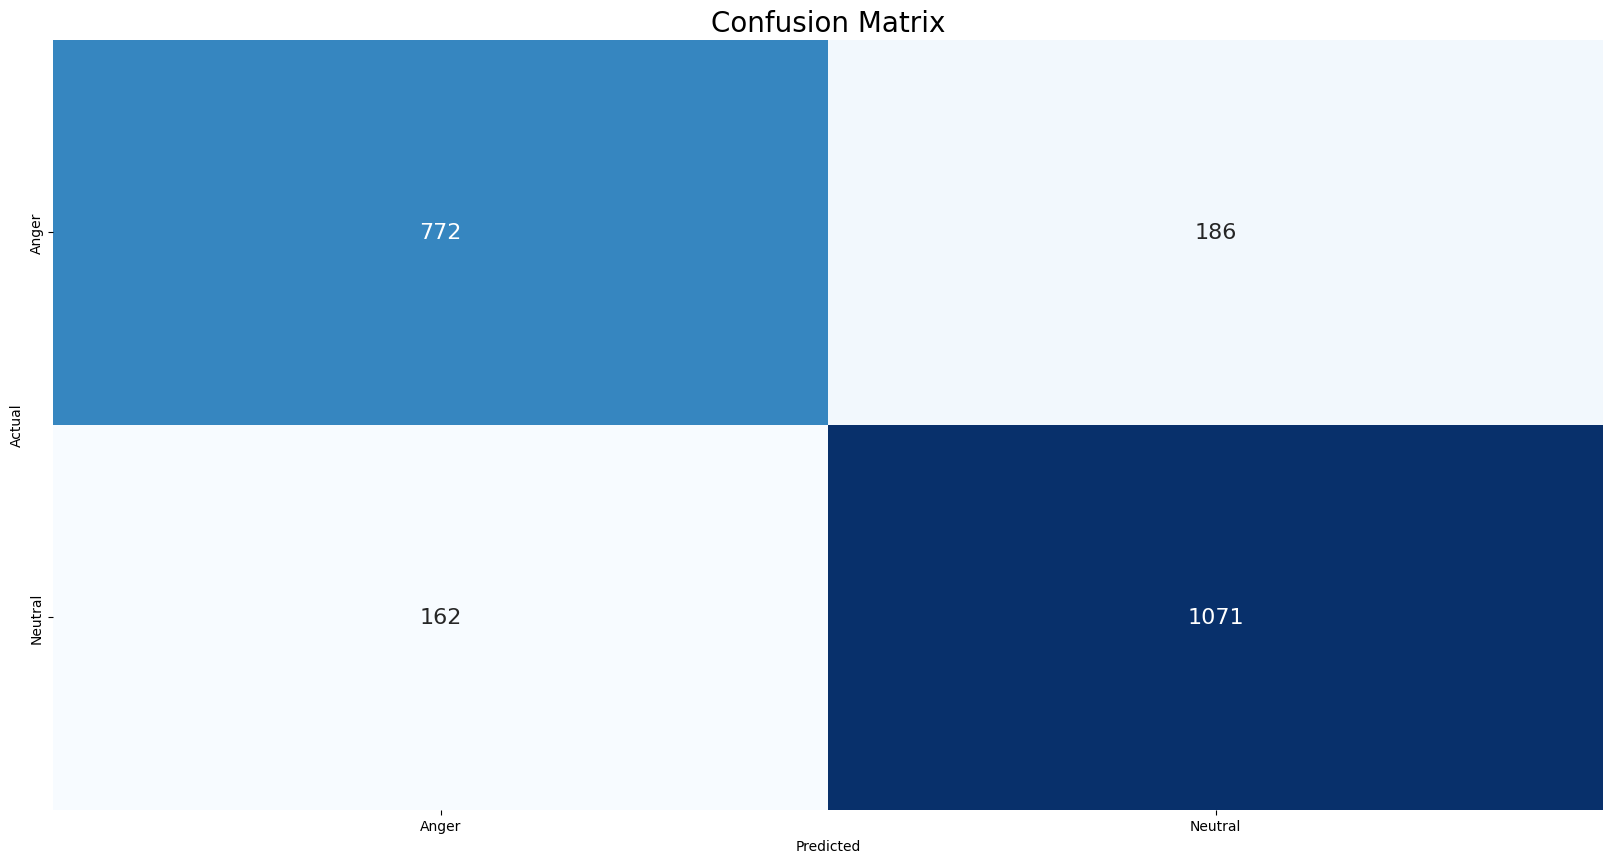

In [ ]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

#print the classification report

In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       958
           1       0.85      0.87      0.86      1233

    accuracy                           0.84      2191
   macro avg       0.84      0.84      0.84      2191
weighted avg       0.84      0.84      0.84      2191



#start with the second system (physical records analysis)


#unzip the data folder

In [ ]:
!pip install rarfile
import rarfile
with rarfile.RarFile('/content/vicon+physical+action+data+set.zip', 'r') as rar_ref:
    rar_ref.extractall()

#defin function to load the data

In [ ]:
import pandas as pd
import numpy as np
import os

def load_and_preprocess_data(path_data):
    """
    Load and preprocess data from the Vicon Physical Action Data Set.

    Parameters:
    - path_data (str): Path to the root directory of the dataset.

    Returns:
    - data (list): List containing the loaded data.
    - lbl_20_class (list): List containing labels for each sample in 20 classes.
    """

    # Initialize lists to store data and labels
    lbl_binary = list()
    lbl_20_class = list()
    data = []

    # Loop through folders in the dataset
    for folder in os.listdir(path_data):
        path_in = os.path.join(path_data, folder)

        # Loop through subfolders in each folder
        for sub_folder in os.listdir(path_in):
            print('---------{0}------------'.format(sub_folder))
            path_in2 = os.path.join(path_in, sub_folder)

            # Loop through files in each subfolder
            for file_name in os.listdir(path_in2):
                lbl_one = file_name[:-4]
                print(file_name[:-4])

                # Read data from the file using pandas
                path_file = os.path.join(path_in2, file_name)
                txt_data = np.array(pd.read_csv(path_file, delim_whitespace=True))
                txt_data = txt_data[:, 1:]

                # Extend the data list with the loaded data
                data.extend(txt_data)

                # Generate labels for each sample in 20 classes
                lbl_all = ((lbl_one + ',') * txt_data.shape[0]).split(',')[:-1]
                lbl_20_class.extend(lbl_all)

                print(txt_data.shape)

    return data, lbl_20_class

data, lbl_20_class = load_and_preprocess_data('/content/Vicon Physical Action Data Set')


---------normal------------
Seating
(4244, 27)
Waving
(4305, 27)
Jumping
(4054, 27)
Standing
(3838, 27)
Clapping
(3952, 27)
Running
(4269, 27)
Bowing
(4272, 27)
Handshaking
(4197, 27)
Walking
(6373, 27)
Hugging
(4335, 27)
---------aggressive------------
Frontkicking
(4146, 27)
Hamering
(6242, 27)
Pulling
(6399, 27)
Pushing
(4260, 27)
Slapping
(6519, 27)
Kneeing
(5516, 27)
Sidekicking
(4174, 27)
Elbowing
(4119, 27)
Punching
(4232, 27)
Headering
(3706, 27)
---------normal------------
Seating
(1888, 27)
Waving
(2193, 27)
Jumping
(2285, 27)
Standing
(1999, 27)
Clapping
(2066, 27)
Running
(1059, 27)
Bowing
(1944, 27)
Handshaking
(1778, 27)
Walking
(1645, 27)
Hugging
(1624, 27)
---------aggressive------------
Frontkicking
(1925, 27)
Hamering
(1893, 27)
Pulling
(1988, 27)
Pushing
(1508, 27)
Slapping
(1954, 27)
Kneeing
(1793, 27)
Sidekicking
(1986, 27)
Elbowing
(1691, 27)
Punching
(2167, 27)
Headering
(1885, 27)
---------normal------------
Seating
(6779, 27)
Waving
(4048, 27)
Jumping
(4215, 27

#preprocessing the data

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np

def preprocess_data(data, lbl_20_class):
    """
    Preprocess the data and labels using LabelEncoder and MinMaxScaler.

    Parameters:
    - data (list): List containing the loaded data.
    - lbl_20_class (list): List containing labels for each sample in 20 classes.

    Returns:
    - Data_main (numpy.ndarray): Preprocessed data using MinMaxScaler.
    - Data_label (numpy.ndarray): Encoded labels using LabelEncoder.
    """

    print('-----------Preprocessing----------------')

    # Initialize LabelEncoder
    encoder = LabelEncoder()

    # Encode the 20-class labels using LabelEncoder
    lbl_20_class = np.array(lbl_20_class)
    lbl_20_class = encoder.fit_transform(lbl_20_class.reshape(-1, 1))

    # Print the encoded labels
    print(lbl_20_class)

    # Separate data and labels
    Data_label = lbl_20_class
    Data_main = np.array(data)

    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Fit and transform the data using MinMaxScaler
    scaler.fit(Data_main)
    Data_main = scaler.transform(Data_main)

    # Print the preprocessed data
    print(Data_main)

    return Data_main, Data_label

# Example usage:
# Assuming loaded_data and labels_20_classes are defined before calling the function
Data_main, Data_label = preprocess_data(data, lbl_20_class)


-----------Preprocessing----------------
[15 15 15 ...  6  6  6]
[[0.46758725 0.35824329 0.58104704 ... 0.52972986 0.53253634 0.08732088]
 [0.46758725 0.35824329 0.58104704 ... 0.52972986 0.53253634 0.08732088]
 [0.46758491 0.35821252 0.58103576 ... 0.52972986 0.53253634 0.08732088]
 ...
 [0.63005261 0.35064031 0.69558597 ... 0.72931357 0.31153287 0.13836476]
 [0.63005261 0.35064031 0.69558597 ... 0.72931357 0.31153287 0.13836476]
 [0.63254589 0.35108819 0.69489047 ... 0.72931357 0.31153287 0.13836476]]


In [ ]:
!pip install pytictoc

#import important libraries for modeling

In [ ]:
import numpy as np
import os
from pytictoc import TicToc
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [ ]:

def run_several_ML_DL_algorithms(Train_data,Test_data,Train_lable,Test_lable,str_out):


    print(np.shape(Test_data))
    print(np.shape(Train_data))
    print(np.shape(Train_lable))
    print(np.shape(Test_lable))

    algorithms_name=['DT','KNN','NB','MLP','LR']
    alg_num=len(algorithms_name)
    accuracy_array=np.zeros(alg_num)
    precision_array=np.zeros(alg_num)
    recall_array=np.zeros(alg_num)
    f1_score_array=np.zeros(alg_num)
    time_array=np.zeros(alg_num)

    t = TicToc()


    print('---------------------DT---------------------')
    K=0;
    t.tic() #Start timer
    classifier_DT = DecisionTreeClassifier(max_depth=1000,random_state=0)
    classifier_DT.fit(Train_data, Train_lable)
    Test_predict = classifier_DT.predict(Test_data)
    Con_matrix=confusion_matrix(Test_lable, Test_predict)
    TimeDT=t.tocvalue() #Time elapsed since t.tic()
    classfi_report=classification_report(Test_lable, Test_predict,output_dict=True)

    # save to array
    accuracy_array[K]=accuracy_score(Test_lable, Test_predict)
    precision_array[K]= classfi_report['macro avg']['precision']
    recall_array[K]= classfi_report['macro avg']['recall']
    f1_score_array[K]= classfi_report['macro avg']['f1-score']
    time_array[K]=TimeDT
    print(accuracy_array[K])


    print('--------------NB----------------')
    K+=1;
    t.tic() #Start timer
    classifier = MultinomialNB()
    classifier.fit(Train_data, Train_lable)
    Test_predict = classifier.predict(Test_data)
    TimeNB=t.tocvalue() #Time elapsed since t.tic()
    Con_matrix=confusion_matrix(Test_lable, Test_predict)
    classfi_report=classification_report(Test_lable, Test_predict,output_dict=True)


    # save to array
    accuracy_array[K]=accuracy_score(Test_lable, Test_predict)
    precision_array[K]= classfi_report['macro avg']['precision']
    recall_array[K]= classfi_report['macro avg']['recall']
    f1_score_array[K]= classfi_report['macro avg']['f1-score']
    time_array[K]=TimeNB
    print(accuracy_array[K])
    print('---------------------KNN---------------------')
    K+=1;
    t.tic() #Start timer
    classifier=KNeighborsClassifier(n_neighbors=10)
    classifier.fit(Train_data, Train_lable)
    Test_predict = classifier.predict(Test_data)
    TimeKNN=t.tocvalue() #Time elapsed since t.tic()
    Con_matrix=confusion_matrix(Test_lable, Test_predict)
    classfi_report=classification_report(Test_lable, Test_predict,output_dict=True)

    # save to array
    accuracy_array[K]=accuracy_score(Test_lable, Test_predict)
    precision_array[K]= classfi_report['macro avg']['precision']
    recall_array[K]= classfi_report['macro avg']['recall']
    f1_score_array[K]= classfi_report['macro avg']['f1-score']
    time_array[K]=TimeKNN
    print(accuracy_array[K])

    print('---------------------MLP---------------------')
    K+=1;
    t.tic() #Start timer
    classifier=MLPClassifier( solver='adam', random_state=0,hidden_layer_sizes=[5], max_iter=200)
    classifier.fit(Train_data, Train_lable)
    Test_predict = classifier.predict(Test_data)
    TimeMLP=t.tocvalue() #Time elapsed since t.tic()
    Con_matrix=confusion_matrix(Test_lable, Test_predict)
    classfi_report=classification_report(Test_lable, Test_predict,output_dict=True)

    # save to array
    accuracy_array[K]=accuracy_score(Test_lable, Test_predict)
    precision_array[K]= classfi_report['macro avg']['precision']
    recall_array[K]= classfi_report['macro avg']['recall']
    f1_score_array[K]= classfi_report['macro avg']['f1-score']
    time_array[K]=TimeMLP
    print(accuracy_array[K])

    print('---------------------LogisticRegression---------------------')
    K+=1;
    t.tic() #Start timer
    classifier=LogisticRegression()
    classifier.fit(Train_data, Train_lable)
    Test_predict = classifier.predict(Test_data)
    TimeLR=t.tocvalue() #Time elapsed since t.tic()
    Con_matrix=confusion_matrix(Test_lable, Test_predict)
    classfi_report=classification_report(Test_lable, Test_predict,output_dict=True)

    # save to array
    accuracy_array[K]=accuracy_score(Test_lable, Test_predict)
    precision_array[K]= classfi_report['macro avg']['precision']
    recall_array[K]= classfi_report['macro avg']['recall']
    f1_score_array[K]= classfi_report['macro avg']['f1-score']
    time_array[K]=TimeLR
    print(accuracy_array[K])


    H=6
    L=8





    print('--------------------result--------------------------')
    fig1=plt.figure(figsize=(H, L)) #
    plt.bar(algorithms_name, accuracy_array,color = ['red', 'green'])
    plt.xticks(algorithms_name, rotation=70)
    plt.ylabel('percent%')
    plt.title('Accuracy of all Algorithm')
    plt.xlabel("Algoritm names")
    for i, v in enumerate(accuracy_array):
        v=round(v,2)
        plt.text(i-0.2 , v+0.01 , str(v), color='blue', fontweight='bold')
    fig1.show()
    plt.savefig(os.path.join(str_out+' accuracy.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures


    fig2=plt.figure(figsize=(H, L)) #
    plt.bar(algorithms_name, precision_array,color = ['red', 'green'])
    plt.xticks(algorithms_name, rotation=70)
    plt.ylabel('percent%')
    plt.title('Precision of all Algorithm')
    plt.xlabel("Algoritm names")
    for i, v in enumerate(precision_array):
        v=round(v,2)
        plt.text(i-0.2 , v+0.01 , str(v), color='blue', fontweight='bold')
    fig2.show()
    plt.savefig(os.path.join(str_out+' precision.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures




    fig3=plt.figure(figsize=(H, L)) #
    plt.bar(algorithms_name, recall_array,color = ['red', 'green'])
    plt.xticks(algorithms_name, rotation=70)
    plt.ylabel('percent%')
    plt.title('Recallof all Algorithm')
    plt.xlabel("Algoritm names")
    for i, v in enumerate(recall_array):
        v=round(v,2)
        plt.text(i-0.2 , v+0.01 , str(v), color='blue', fontweight='bold')
    fig3.show()
    plt.savefig(os.path.join(str_out+' recall.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures



    fig4=plt.figure(figsize=(H, L)) #
    plt.bar(algorithms_name, f1_score_array,color = ['red', 'green'])
    plt.xticks(algorithms_name, rotation=70)
    plt.ylabel('percent%')
    plt.title('f1-score of all Algorithm')
    plt.xlabel("Algoritm names")
    for i, v in enumerate(f1_score_array):
        v=round(v,2)
        plt.text(i-0.2 , v+0.01 , str(v), color='blue', fontweight='bold')
    fig4.show()
    plt.savefig(os.path.join(str_out+' f1_score.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures



    fig5=plt.figure(figsize=(H, L)) #
    plt.bar(algorithms_name, time_array,color = ['blue', 'green'])
    plt.xticks(algorithms_name, rotation=70)
    plt.ylabel('time(s)')
    plt.title('time of all Algorithm')
    plt.xlabel("Algoritm names")
    for i, v in enumerate(time_array):
        v=round(v,2)
        plt.text(i-0.2 , v+0.01 , str(v), color='blue', fontweight='bold')
    plt.savefig(os.path.join(str_out+' time.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures
    fig5.show()


    np.savetxt(str_out+'accuracy.csv', accuracy_array, delimiter=',')
    np.savetxt(str_out+' precision_array.csv', precision_array, delimiter=',')
    np.savetxt(str_out+'recall_array.csv', recall_array, delimiter=',')
    np.savetxt(str_out+' time_array.csv', time_array, delimiter=',')
    np.savetxt(str_out+' f1-score.csv', f1_score_array, delimiter=',')

In [ ]:
from sklearn.model_selection import train_test_split
Train_data, Test_data, Train_lable, Test_lable = train_test_split(Data_main, Data_label, test_size=0.20)


(121037, 27)
(484144, 27)
(484144,)
(121037,)
---------------------DT---------------------
0.9984798036963903
--------------NB----------------
0.18519130513809826
---------------------KNN---------------------
0.9984963275692557
---------------------MLP---------------------
0.507472921503342
---------------------LogisticRegression---------------------
0.5318125862339615
--------------------result--------------------------


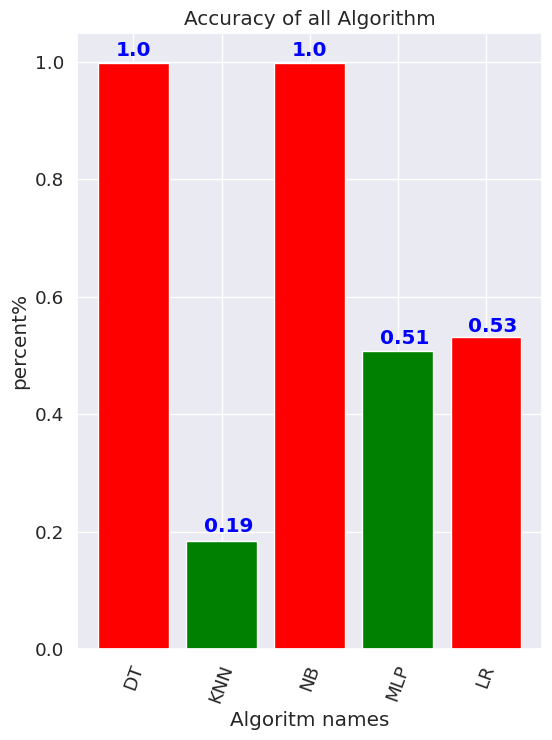

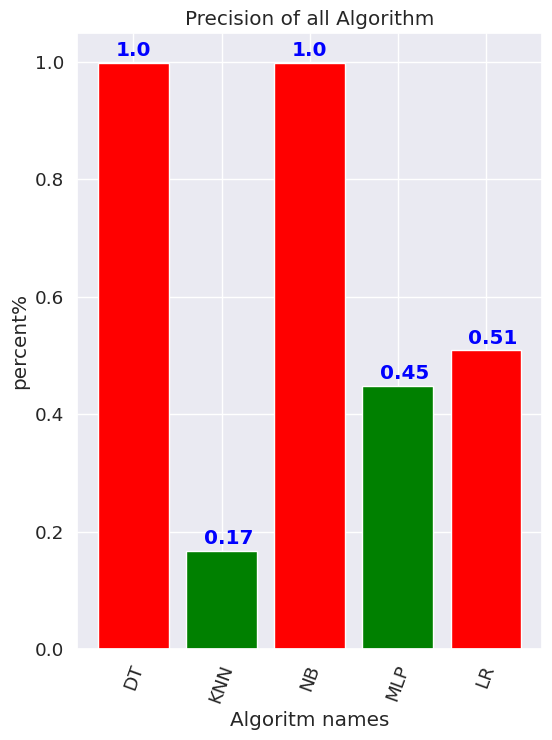

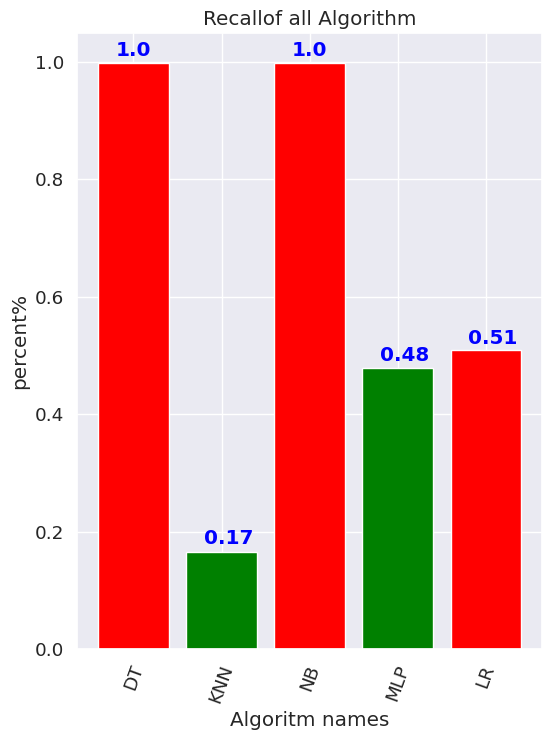

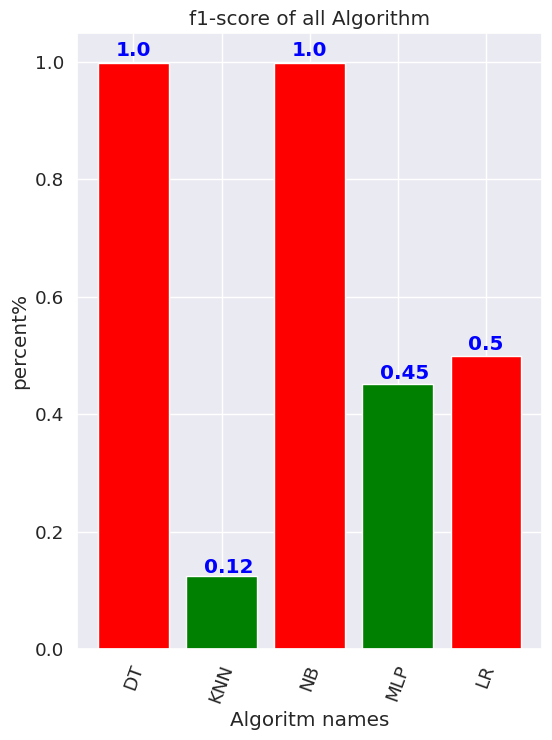

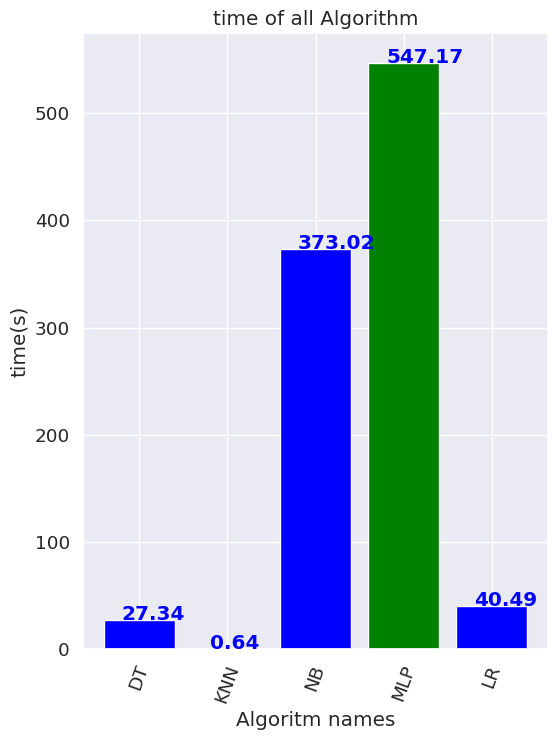

In [ ]:
run_several_ML_DL_algorithms(Train_data, Test_data, Train_lable, Test_lable ,"")

#build the third system (netwok protocols analysis)

#import the important libraries

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
import xgboost as xgb
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

#read the data set using pandas

In [ ]:
data_path="/content/data.csv"
data = pd.read_csv(data_path)

#explore the data set

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7199 entries, 0 to 7198
Data columns (total 42 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       7199 non-null   int64  
 1   0.1     7199 non-null   int64  
 2   0.2     7199 non-null   int64  
 3   7       7199 non-null   int64  
 4   65      7199 non-null   int64  
 5   7.1     7199 non-null   int64  
 6   71      7199 non-null   int64  
 7   9       7199 non-null   int64  
 8   6       7199 non-null   int64  
 9   11      7199 non-null   int64  
 10  6.1     7199 non-null   int64  
 11  23      7199 non-null   int64  
 12  95      7199 non-null   int64  
 13  5       7199 non-null   int64  
 14  11.1    7199 non-null   int64  
 15  1.2     7199 non-null   float64
 16  5.1     7199 non-null   int64  
 17  1       7199 non-null   int64  
 18  0.3     7199 non-null   int64  
 19  0.4     7199 non-null   int64  
 20  0.5     7199 non-null   int64  
 21  0.6     7199 non-null   int64  
 22  

In [ ]:
data.describe()

,0,0.1,0.2,7,65,7.1,71,9,6,11,...,0.16,0.17,0.18,0.19,0.20,65.1,0.21,0.22,208,-1
count,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000,...,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000
mean,1179.663842,11.501597,29.504098,2.135991,202.735936,8.453118,748.881095,72.141686,6.027782,13.387276,...,0.104737,0.100986,0.106543,0.093068,0.057925,198.538408,0.251424,5.805806,251.827198,-0.933324
std,692.391869,6.921821,17.317017,2.702377,737.913875,2.673383,3630.482189,406.533328,0.814945,4.512005,...,0.306235,0.301331,0.308552,0.290549,0.233617,725.231555,1.176842,22.227525,43.219695,0.359060
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,15.000000,0.000000,4.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,190.000000,-1.000000
25%,600.000000,6.000000,15.000000,0.000000,57.000000,7.000000,106.000000,16.000000,6.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,56.000000,0.000000,0.000000,230.000000,-1.000000
50%,1200.000000,12.000000,30.000000,1.000000,77.000000,8.000000,162.000000,29.000000,6.000000,13.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,75.000000,0.000000,2.000000,243.000000,-1.000000
75%,1779.500000,17.500000,44.500000,3.000000,112.000000,10.000000,287.000000,48.000000,6.000000,15.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,109.000000,0.000000,5.000000,264.000000,-1.000000
max,2359.000000,23.000000,59.000000,21.000000,15607.000000,37.000000,84500.000000,13591.000000,11.000000,42.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,14918.000000,25.000000,936.000000,1736.000000,1.000000


In [ ]:
data.columns

Index(['0', '0.1', '0.2', '7', '65', '7.1', '71', '9', '6', '11', '6.1', '23',
       '95', '5', '11.1', '1.2', '5.1', '1', '0.3', '0.4', '0.5', '0.6', '0.7',
       '0.8', '0.9', '0.10', '0.11', '0.12', '0.13', '0.14', '0.15', '1.1',
       '0.16', '0.17', '0.18', '0.19', '0.20', '65.1', '0.21', '0.22', '208',
       '-1'],
      dtype='object')

#rename the columns

In [ ]:
import pandas as pd

def rename_columns(data):
    # Create a dictionary to map the old column names to the new names
    column_mapping1 = {
        '0': 'time_H_M',
        '0.1': 'time_H',
        '0.2': 'time_M',
        '7': 'time_S',
    }

    data.rename(columns=column_mapping1, inplace=True)

    # Get the original column names from 4 to 41
    original_columns = data.columns[4:42]

    # Generate new column names
    new_columns = [f'feature_{i+1}' for i in range(37)]

    # Create a dictionary to map old column names to new names
    column_mapping2 = dict(zip(original_columns, new_columns))

    # Rename the columns
    data.rename(columns=column_mapping2, inplace=True)

    # Create a dictionary to map the old column name '-1' to 'target'
    column_mapping3 = {
        '-1': 'target',
    }

    # Use the rename method to rename the columns
    data.rename(columns=column_mapping3, inplace=True)

#call the function to rename the columns

In [ ]:
rename_columns(data)

#check for the new column's names

In [ ]:
data.columns

Index(['time_H_M', 'time_H', 'time_M', 'time_S', 'feature_1', 'feature_2',
       'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7',
       'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22',
       'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27',
       'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32',
       'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37',
       'target'],
      dtype='object')

#start preprocessing the data

* replace the value -1 with value 0 in the target column
* Solve the problem of imbalance between the labels
* Scaling and normalization on the data
* define the Features and the Target
* split the data into train and test


In [ ]:
data['target'] = data['target'].replace(-1, 0)

In [ ]:
# The data label is unbalanced
data["target"].value_counts()

0    6959
1     240
Name: target, dtype: int64

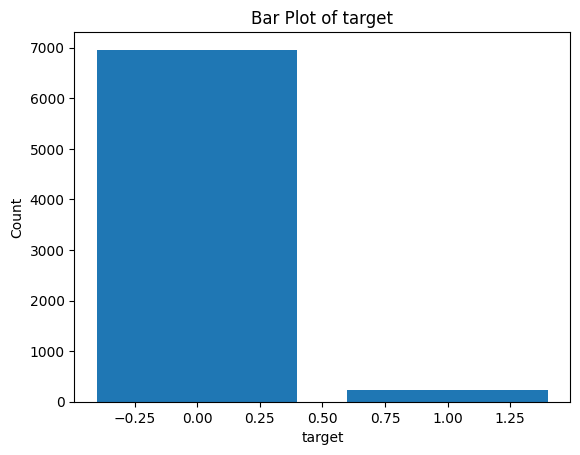

In [ ]:

# Count the occurrences of each unique value in the 'Category' column
value_counts = data['target'].value_counts()

# Plot the bar chart
plt.bar(value_counts.index, value_counts.values)

# Add labels and title
plt.xlabel('target')
plt.ylabel('Count')
plt.title('Bar Plot of target')

# Show the plot
plt.show()

In [ ]:
#solve the problem with SMOTE
lab=data["target"]
smote = SMOTE(sampling_strategy={1: 7000, 0: 7000}, random_state=42)
data, lab = smote.fit_resample(data, lab)

/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (7000) in class 1 will be larger than the number of samples in the majority class (class #0 -> 6959)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (7000) in class 0 will be larger than the number of samples in the majority class (class #0 -> 6959)
  warnings.warn(


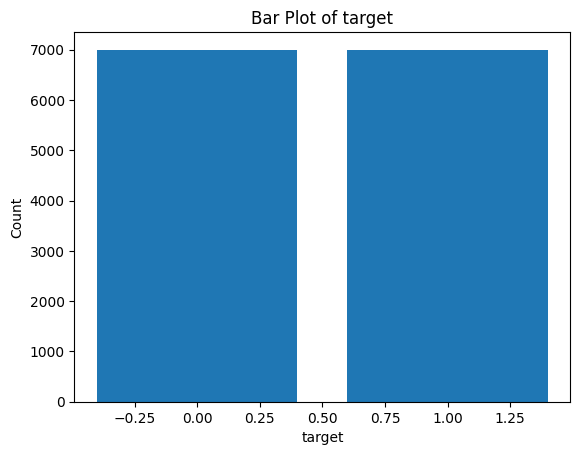

In [ ]:
#verify that the imbalance problem is solved

# Count the occurrences of each unique value in the 'Category' column
value_counts = data['target'].value_counts()

# Plot the bar chart
plt.bar(value_counts.index, value_counts.values)

# Add labels and title
plt.xlabel('target')
plt.ylabel('Count')
plt.title('Bar Plot of target')

# Show the plot
plt.show()

# Extract features and target variables

In [ ]:
X = data.iloc[:, 4:41]  # Features (columns 4 to 40)
y = data['target']   # Target (column 41)


# Split the data into training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Scale and normalize the features using Min-Max scaling

In [ ]:

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

# Fit and evaluate machine learning models

#support vectors machine (SVM)

In [ ]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_accuracy = svm_model.score(X_test, y_test)
print(f"SVM Accuracy: {svm_accuracy:.2f}")
# Make predictions on the test set
svm_predictions = svm_model.predict(X_test)
# Calculate precision, recall, and F1-score for SVM model
svm_precision = precision_score(y_test, svm_predictions)
svm_recall = recall_score(y_test, svm_predictions)
svm_f1 = f1_score(y_test, svm_predictions)
print("SVM Precision:", svm_precision)
print("SVM Recall:", svm_recall)
print("SVM F1 Score:", svm_f1)


SVM Accuracy: 0.96
SVM Precision: 0.9657933042212519
SVM Recall: 0.9581227436823104
SVM F1 Score: 0.9619427328742298


# Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_accuracy = dt_model.score(X_test, y_test)
print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")
# Make predictions on the test set
dt_predictions = dt_model.predict(X_test)
# Calculate precision, recall, and F1-score for DT model
dt_precision = precision_score(y_test, dt_predictions)
dt_recall = recall_score(y_test, dt_predictions)
dt_f1 = f1_score(y_test, dt_predictions)
print("\nDecision Tree Precision:", dt_precision)
print("Decision Tree Recall:", dt_recall)
print("Decision Tree F1 Score:", dt_f1)

Decision Tree Accuracy: 0.98

Decision Tree Precision: 0.9673295454545454
Decision Tree Recall: 0.9833935018050541
Decision Tree F1 Score: 0.9752953813104188




# Random Forest


In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_accuracy = rf_model.score(X_test, y_test)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
# Make predictions on the test set
rf_predictions = rf_model.predict(X_test)
# Calculate precision, recall, and F1-score for RF model
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)
print("\nRandom Forest Precision:", rf_precision)
print("Random Forest Recall:", rf_recall)
print("Random Forest F1 Score:", rf_f1)

Random Forest Accuracy: 0.99

Random Forest Precision: 0.9956427015250545
Random Forest Recall: 0.9898916967509025
Random Forest F1 Score: 0.99275887038378



# XGBoost

In [ ]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_accuracy = xgb_model.score(X_test, y_test)
print(f"XGBoost Accuracy: {xgb_accuracy:.2f}")
# Make predictions on the test set
xgboost_predictions = xgb_model.predict(X_test)
# Calculate precision, recall, and F1-score for XGboost model
xgboost_precision = precision_score(y_test, xgboost_predictions)
xgboost_recall = recall_score(y_test, xgboost_predictions)
xgboost_f1 = f1_score(y_test, xgboost_predictions)
print("\nXGBoost Precision:", xgboost_precision)
print("XGBoost Recall:", xgboost_recall)
print("XGBoost F1 Score:", xgboost_f1)

XGBoost Accuracy: 0.99

XGBoost Precision: 0.9928005759539237
XGBoost Recall: 0.9956678700361011
XGBoost F1 Score: 0.9942321557317952


#make predictions to detect the normal and anomalous nodes

In [ ]:
# Select the first 30 rows from X_test
subset_X_test = X_test[:30]
# Make predictions on the subset_X_test using random forest
rf_predictions = rf_model.predict(subset_X_test)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a NetworkX graph
G = nx.Graph()

# Define the dimensions of the grid
num_rows = 5
num_cols = 6

# Create nodes in a grid pattern
for row in range(num_rows):
    for col in range(num_cols):
        node_name = f"node_{row}_{col}"
        G.add_node(node_name, pos=(col, -row))


# Add anomalous and normal nodes based on predictions
for i, prediction in enumerate(rf_predictions):
    node_name = f"node_{i // num_cols}_{i % num_cols}"
    G.nodes[node_name]['anomalous'] = prediction == 0



# Create layout for the grid

In [ ]:

pos = {node: (col, -row) for node, (col, row) in nx.get_node_attributes(G, 'pos').items()}

# Add edges to connect adjacent nodes in the grid
for row in range(num_rows):
    for col in range(num_cols):
        current_node_name = f"node_{row}_{col}"
        if row > 0:
            neighbor_node_name = f"node_{row - 1}_{col}"
            G.add_edge(current_node_name, neighbor_node_name)
        if col > 0:
            neighbor_node_name = f"node_{row}_{col - 1}"
            G.add_edge(current_node_name, neighbor_node_name)



# Separate anomalous and normal nodes

In [ ]:

anomalous_nodes = [node for node, data in G.nodes(data=True) if data.get('anomalous')]
normal_nodes = [node for node in G.nodes() if node not in anomalous_nodes]



# Draw the graph

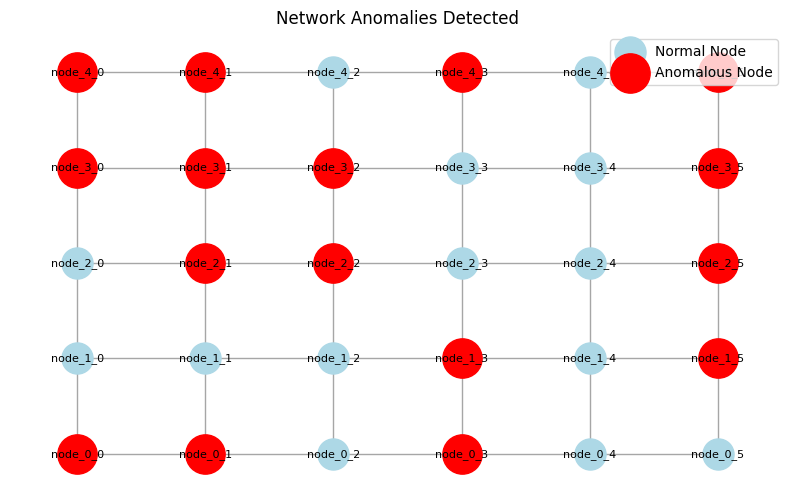

In [ ]:

plt.figure(figsize=(10, 6))
nx.draw_networkx_nodes(G, pos, nodelist=normal_nodes, node_color='lightblue', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=anomalous_nodes, node_color='red', node_size=800)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=1, alpha=0.7, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Network Anomalies Detected")
plt.legend(["Normal Node", "Anomalous Node"])
plt.axis('off')  # Turn off the axis

# Display the graph
plt.show()
